# **Project Name**: Amazon Delivery Time Prediction

##### **Project Type**    - EDA/machine Learning/Streamlit
##### **Contribution**    - Individual
##### **Team Member 1**   - Gade Pavan Kumar Reddy

# **Project Summary -**

This project focuses on predicting Amazon delivery times using machine learning. The dataset included order, agent, traffic, and weather details. After cleaning and feature engineering, we explored the data to understand key patterns, such as the effect of weekdays and traffic on delivery delays.

Multiple models were tested, including Linear Regression, Random Forest, Gradient Boosting, and XGBoost. Among these, XGBoost achieved the best results with an R² of 0.81, showing strong predictive power.

To make the solution practical, we built a Streamlit app where users can input details like distance, weather, and traffic to receive instant delivery time predictions. This end-to-end pipeline—from raw data to a user-facing app—demonstrates how machine learning can optimize logistics and improve customer experience in e-commerce.

# **GitHub Link -**

**Link** - https://github.com/pavangade31/Amazon-Delivery-Time-Prediction-Project

# **Problem Statement**

In today’s e-commerce landscape, timely delivery is a critical factor in customer satisfaction and retention. Amazon, like many delivery-driven platforms, faces the challenge of accurately predicting delivery times amid numerous uncertainties such as traffic, weather, distance, and operational delays. Traditional methods often fail to account for these dynamic factors, leading to delays, inefficiencies, and reduced customer trust.

The problem, therefore, is to develop a predictive model that can estimate delivery times more accurately using historical order and agent data. By analyzing patterns in order details, agent performance, geographical distances, and environmental conditions, the model aims to provide businesses with reliable delivery time estimates. Such predictions can improve planning, optimize resource allocation, and ultimately enhance the overall customer experience in last-mile logistics.

# ***Let's Begin !***

## 1. Data Loading and Understanding

In [1]:
import warnings
warnings.filterwarnings('ignore')

### Import Libraries

In [2]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import joblib

### Load the Dataset

In [3]:
df = pd.read_csv("amazon_delivery.csv")

### Dataset First View

In [4]:
df.head()

,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category
0,ialx566343618,37,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,High,motorcycle,Urban,120,Clothing
1,akqg208421122,34,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,Jam,scooter,Metropolitian,165,Electronics
2,njpu434582536,23,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,Low,motorcycle,Urban,130,Sports
3,rjto796129700,38,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics
4,zguw716275638,32,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,High,scooter,Metropolitian,150,Toys


### Dataset Rows and Columns Count

In [5]:
print(f"No of rows in dataset: {df.shape[0]}")
print(f"No of columns in dataset: {df.shape[1]}")

No of rows in dataset: 43739
No of columns in dataset: 16


### Missing values

In [6]:
df.isnull().sum()

Order_ID            0
Agent_Age           0
Agent_Rating       54
Store_Latitude      0
Store_Longitude     0
Drop_Latitude       0
Drop_Longitude      0
Order_Date          0
Order_Time          0
Pickup_Time         0
Weather            91
Traffic             0
Vehicle             0
Area                0
Delivery_Time       0
Category            0
dtype: int64

### Dataset Duplicates

In [7]:
df.duplicated().sum()

0

### Handling the Missing Values`

In [8]:
df["Agent_Rating"] = df["Agent_Rating"].fillna(df["Agent_Rating"].median())
df["Weather"] = df["Weather"].fillna(df["Weather"].mode()[0])

### Intial Check for the Datatypes in the DataFrame

In [9]:
df.dtypes

Order_ID            object
Agent_Age            int64
Agent_Rating       float64
Store_Latitude     float64
Store_Longitude    float64
Drop_Latitude      float64
Drop_Longitude     float64
Order_Date          object
Order_Time          object
Pickup_Time         object
Weather             object
Traffic             object
Vehicle             object
Area                object
Delivery_Time        int64
Category            object
dtype: object

### Converting the Date and Time columns and Category Columns

In [10]:
# Convert dates to datetime
df["Order_Date"] = pd.to_datetime(df["Order_Date"], errors="coerce")
df["Order_Time"] = pd.to_datetime(df["Order_Time"], format="%H:%M:%S", errors="coerce")
df["Pickup_Time"] = pd.to_datetime(df["Pickup_Time"], format="%H:%M:%S", errors="coerce")

# Convert categorical variables to category dtype
categorical_cols = ["Weather", "Traffic", "Vehicle", "Area", "Category"]
for col in categorical_cols:
    df[col] = df[col].astype("category")

### Creating new columns from the columns in dataframe

In [11]:
df["Distance_km"] = df.apply(
    lambda row: geodesic(
        (row["Store_Latitude"], row["Store_Longitude"]),
        (row["Drop_Latitude"], row["Drop_Longitude"])
    ).km,
    axis=1
)

df["Order_DayOfWeek"] = df["Order_Date"].dt.dayofweek   # 0=Monday … 6=Sunday
df["Order_Hour"] = df["Order_Time"].dt.hour             # Hour of order
df["Pickup_Delay_min"] = (df["Pickup_Time"] - df["Order_Time"]).dt.total_seconds() / 60

### Final Dataset View

In [12]:
df.head()

,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category,Distance_km,Order_DayOfWeek,Order_Hour,Pickup_Delay_min
0,ialx566343618,37,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,1900-01-01 11:30:00,1900-01-01 11:45:00,Sunny,High,motorcycle,Urban,120,Clothing,3.020737,5,11.0,15.0
1,akqg208421122,34,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,1900-01-01 19:45:00,1900-01-01 19:50:00,Stormy,Jam,scooter,Metropolitian,165,Electronics,20.143737,4,19.0,5.0
2,njpu434582536,23,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,1900-01-01 08:30:00,1900-01-01 08:45:00,Sandstorms,Low,motorcycle,Urban,130,Sports,1.549693,5,8.0,15.0
3,rjto796129700,38,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,1900-01-01 18:00:00,1900-01-01 18:10:00,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics,7.774497,1,18.0,10.0
4,zguw716275638,32,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,1900-01-01 13:30:00,1900-01-01 13:45:00,Cloudy,High,scooter,Metropolitian,150,Toys,6.197898,5,13.0,15.0


### Checking for missing values after data handling

In [13]:
df.isna().sum()

Order_ID             0
Agent_Age            0
Agent_Rating         0
Store_Latitude       0
Store_Longitude      0
Drop_Latitude        0
Drop_Longitude       0
Order_Date           0
Order_Time          91
Pickup_Time          0
Weather              0
Traffic              0
Vehicle              0
Area                 0
Delivery_Time        0
Category             0
Distance_km          0
Order_DayOfWeek      0
Order_Hour          91
Pickup_Delay_min    91
dtype: int64

### Dropping null values from 'Order_Time' column

In [14]:
df = df.dropna(subset=["Order_Time"])

### Checking Final Datatypes of columns in dataframe

In [15]:
df.dtypes

Order_ID                    object
Agent_Age                    int64
Agent_Rating               float64
Store_Latitude             float64
Store_Longitude            float64
Drop_Latitude              float64
Drop_Longitude             float64
Order_Date          datetime64[ns]
Order_Time          datetime64[ns]
Pickup_Time         datetime64[ns]
Weather                   category
Traffic                   category
Vehicle                   category
Area                      category
Delivery_Time                int64
Category                  category
Distance_km                float64
Order_DayOfWeek              int32
Order_Hour                 float64
Pickup_Delay_min           float64
dtype: object

### Checking Final missing values count

In [16]:
df.isna().sum()

Order_ID            0
Agent_Age           0
Agent_Rating        0
Store_Latitude      0
Store_Longitude     0
Drop_Latitude       0
Drop_Longitude      0
Order_Date          0
Order_Time          0
Pickup_Time         0
Weather             0
Traffic             0
Vehicle             0
Area                0
Delivery_Time       0
Category            0
Distance_km         0
Order_DayOfWeek     0
Order_Hour          0
Pickup_Delay_min    0
dtype: int64

### Saving the dataframe into new csv file

In [17]:
df.to_csv('Cleaned_amazon_delivery.csv',index=False)

## 2. Data Visualization and Interpretation

### Loading new dataset

In [18]:
new_df = pd.read_csv("Cleaned_amazon_delivery.csv", parse_dates=["Order_Date","Order_Time","Pickup_Time"])

### Printing Shape and Columns in dataset

In [19]:
print("Shape:", new_df.shape)
print("\nColumns:", new_df.columns.tolist())

Shape: (43648, 20)

Columns: ['Order_ID', 'Agent_Age', 'Agent_Rating', 'Store_Latitude', 'Store_Longitude', 'Drop_Latitude', 'Drop_Longitude', 'Order_Date', 'Order_Time', 'Pickup_Time', 'Weather', 'Traffic', 'Vehicle', 'Area', 'Delivery_Time', 'Category', 'Distance_km', 'Order_DayOfWeek', 'Order_Hour', 'Pickup_Delay_min']


### 1.Distribution of Delivery Time

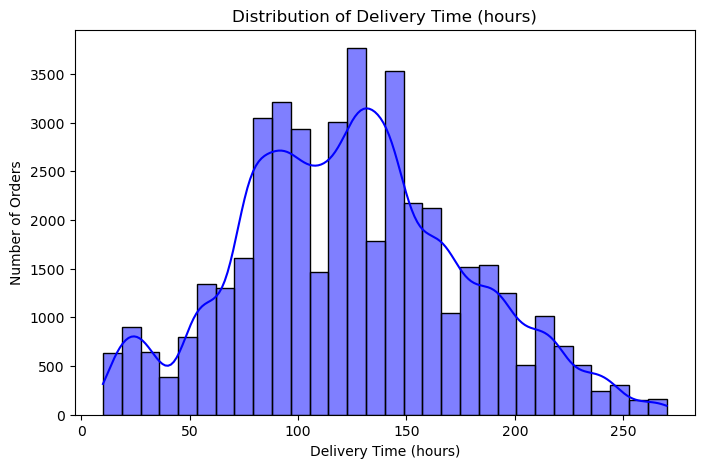

In [20]:
plt.figure(figsize=(8,5))
sns.histplot(df["Delivery_Time"], bins=30, kde=True, color="blue")
plt.title("Distribution of Delivery Time (hours)")
plt.xlabel("Delivery Time (hours)")
plt.ylabel("Number of Orders")
plt.show()

**1.** Most deliveries fall between 80–150 hours, with a noticeable right skew showing some deliveries extending beyond 200 hours.

**2.** The long tail suggests occasional extreme delays that could be influenced by distance or traffic.

### 2.Delivery Time Variation Across Product Categories

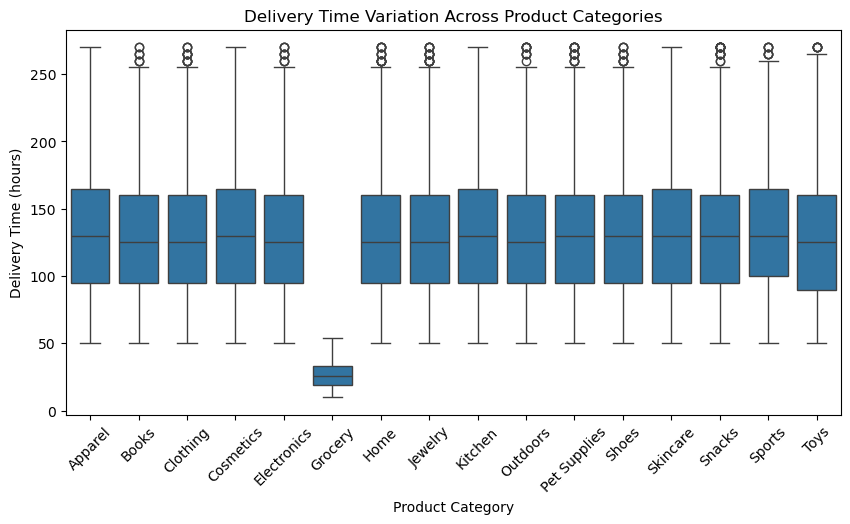

In [21]:
plt.figure(figsize=(10,5))
sns.boxplot(x="Category", y="Delivery_Time", data=df)
plt.title("Delivery Time Variation Across Product Categories")
plt.xlabel("Product Category")
plt.ylabel("Delivery Time (hours)")
plt.xticks(rotation=45)
plt.show()

**1.** Grocery stands out with much shorter delivery times (~20–50 hours), reflecting fast-moving essentials.

**2.** Other categories show median times around 120–150 hours with many outliers, suggesting inconsistent delivery performance.

### 3.Impact of Distance and Traffic on Delivery Time

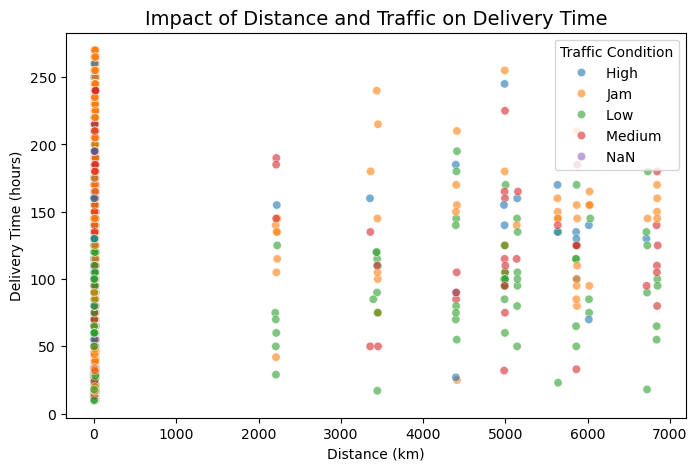

In [22]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="Distance_km", y="Delivery_Time", hue="Traffic", data=df, alpha=0.6)
plt.title("Impact of Distance and Traffic on Delivery Time", fontsize=14)
plt.xlabel("Distance (km)")
plt.ylabel("Delivery Time (hours)")
plt.legend(title="Traffic Condition")
plt.show()

**1.** Delivery time generally increases with distance, but traffic conditions add variation.

**2.** High and jam traffic deliveries tend to cluster at longer times, while low traffic deliveries are faster for similar distances.

### 4.Effect of Weather on Delivery Time

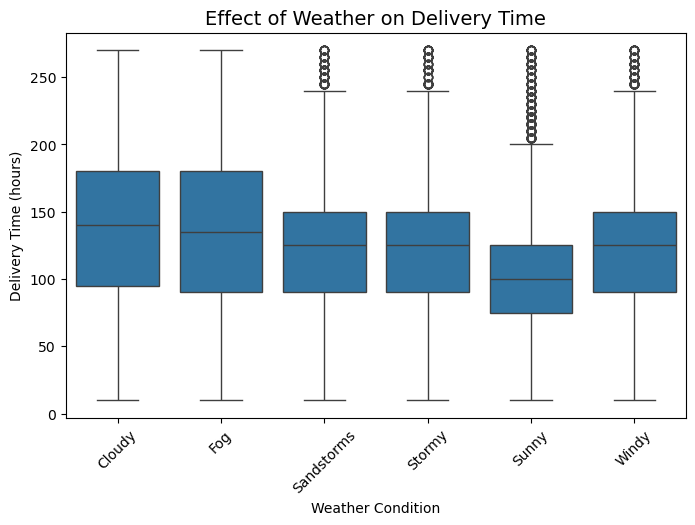

In [23]:
plt.figure(figsize=(8,5))
sns.boxplot(x="Weather", y="Delivery_Time", data=df)
plt.title("Effect of Weather on Delivery Time", fontsize=14)
plt.xlabel("Weather Condition")
plt.ylabel("Delivery Time (hours)")
plt.xticks(rotation=45)
plt.show()

**1.** Sunny conditions allow the fastest deliveries.

**2.** Cloudy and Foggy conditions lead to the longest times, with other weather types showing varied delays and many outliers.

### 5.Relationship Between Agent Rating and Delivery Time (by Area)

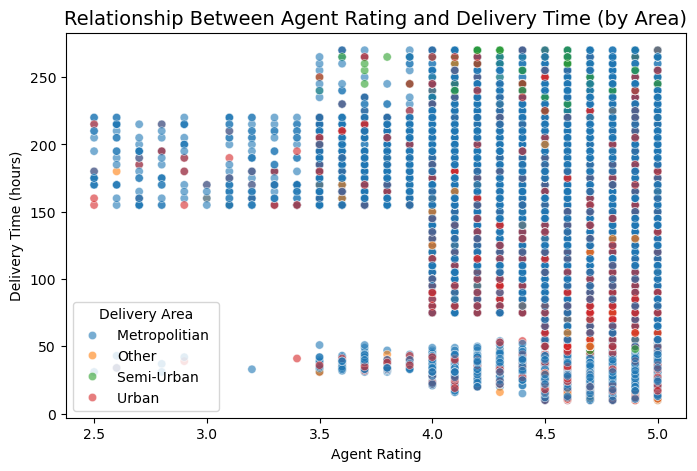

In [24]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="Agent_Rating", y="Delivery_Time", hue="Area", data=df, alpha=0.6)
plt.title("Relationship Between Agent Rating and Delivery Time (by Area)", fontsize=14)
plt.xlabel("Agent Rating")
plt.ylabel("Delivery Time (hours)")
plt.legend(title="Delivery Area")
plt.show()

**1.** Higher agent ratings **(≥4.0)** are generally linked with shorter delivery times, especially in urban areas.

**2.** In metropolitan areas, delivery times remain high despite better ratings, suggesting external factors like traffic congestion may dominate agent efficiency.

### 6.Average Delivery Time by Day of Week

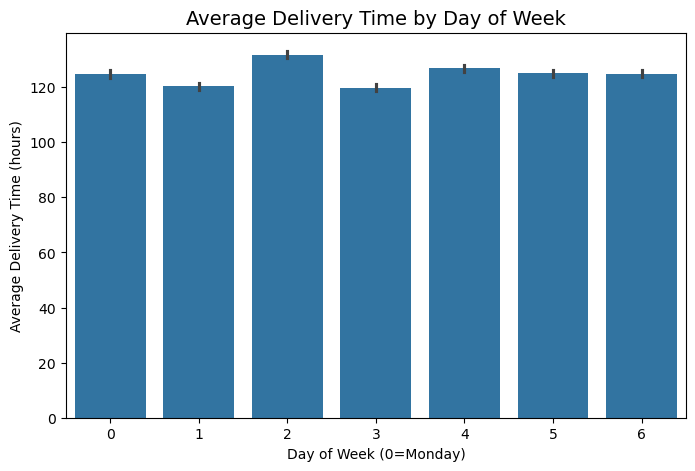

In [25]:
plt.figure(figsize=(8,5))
sns.barplot(x="Order_DayOfWeek", y="Delivery_Time", data=df, estimator="mean")
plt.title("Average Delivery Time by Day of Week", fontsize=14)
plt.xlabel("Day of Week (0=Monday)")
plt.ylabel("Average Delivery Time (hours)")
plt.show()

**1.** Deliveries are fastest on Tuesday and Wednesday (~120 hours), suggesting smoother logistics mid-week.

**2.** Wednesdays (Day 2) show the highest average delivery time (~133 hours), likely due to workload or traffic congestion.

**3.** Overall, delivery times stay fairly consistent across the week with only modest fluctuations.

### 7.Correlation Heatmap (Numeric Features)

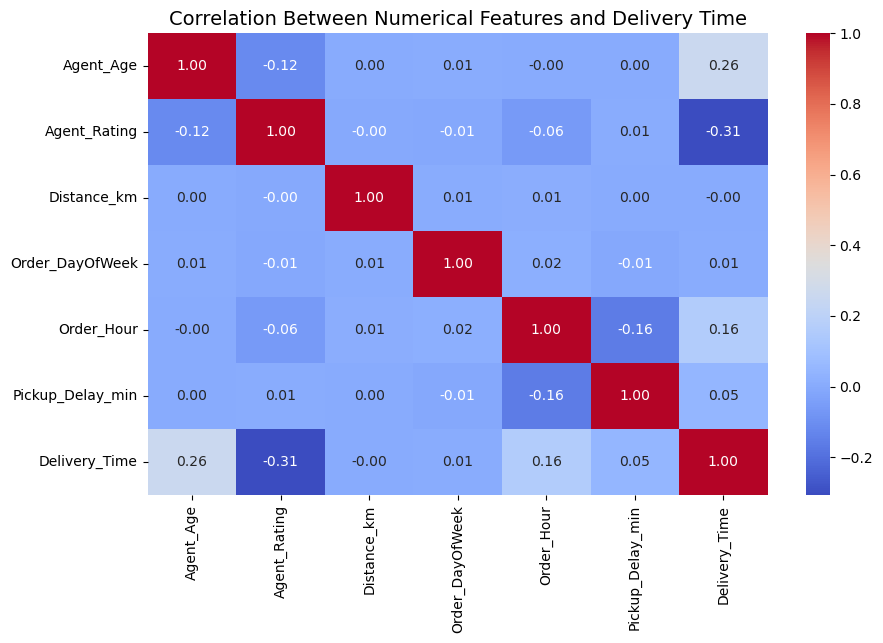

In [26]:
plt.figure(figsize=(10,6))
corr = df[["Agent_Age","Agent_Rating","Distance_km","Order_DayOfWeek",
           "Order_Hour","Pickup_Delay_min","Delivery_Time"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Numerical Features and Delivery Time", fontsize=14)
plt.show()

**1.** Delivery Time has a moderate negative correlation with Agent Rating **(-0.31)**, meaning better-rated agents deliver faster. 

**2.** It also has a mild positive correlation with Agent Age **(0.26)** and Order Hour **(0.16)**, suggesting older agents and later orders slightly increase delivery time. 

**3.** Other features show negligible correlation.

## 3. ML Models Implementation

### Loading new dataset

In [27]:
new2_df = pd.read_csv("Cleaned_amazon_delivery.csv")

### Assigning Features vs Target

In [28]:
X = new2_df.drop(columns=["Order_ID","Order_Date","Order_Time","Pickup_Time","Delivery_Time"])
y = new2_df["Delivery_Time"]

### One-hot encode categorical variables

In [29]:
X = pd.get_dummies(X, drop_first=True)

### Train-Test Split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Defining Models

In [31]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, random_state=42),
    "XGBoost": XGBRegressor(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
}

### Train, Evaluate, Log with MLflow

In [32]:
mlflow.set_experiment("AmazonDeliveryTimePrediction")

<Experiment: artifact_location='file:///C:/Users/pavan/Labmentix/8.Amazon%20Delivery%20Prediction%20project/mlruns/324228926950357845', creation_time=1759555356998, experiment_id='324228926950357845', last_update_time=1759555356998, lifecycle_stage='active', name='AmazonDeliveryTimePrediction', tags={}>

In [33]:
for name, model in models.items():
    with mlflow.start_run(run_name=name):
        # Train
        model.fit(X_train, y_train)

        # Predict
        preds = model.predict(X_test)

        # Metrics
        rmse = mean_squared_error(y_test, preds, squared=False)
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)

        # Print results
        print(f"\n{name}")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE : {mae:.2f}")
        print(f"R²  : {r2:.4f}")

        # Log in MLflow
        mlflow.log_param("model", name)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)
        mlflow.sklearn.log_model(model, name.replace(" ", "_"))

2025/10/05 10:33:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Linear Regression
RMSE: 32.44
MAE : 25.70
R²  : 0.6124


2025/10/05 10:33:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/10/05 10:34:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Random Forest
RMSE: 22.98
MAE : 17.59
R²  : 0.8054


2025/10/05 10:34:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/10/05 10:34:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Gradient Boosting
RMSE: 24.20
MAE : 18.98
R²  : 0.7842


2025/10/05 10:34:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/10/05 10:34:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



XGBoost
RMSE: 22.92
MAE : 17.87
R²  : 0.8065


2025/10/05 10:34:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### Models Interpretations

**1.Linear Regression**

**RMSE: 32.44, R²: 0.61**

Linear Regression served as a baseline model but performed the weakest. Its lower R² shows it struggled to capture the complex, non-linear relationships in the data. It could only explain about 61% of the variance in delivery times, meaning it’s not reliable for accurate predictions in this problem.

**2.Random Forest**

**RMSE: 22.98, R²: 0.80**

Random Forest significantly improved performance compared to Linear Regression. By combining multiple decision trees, it captured non-linear interactions and reduced variance. With an R² of 0.80, it explained 80% of the variance, making it a strong candidate for real-world use.

**3.Gradient Boosting**

**RMSE: 24.20, R²: 0.78**

Gradient Boosting also performed well but slightly lagged behind Random Forest. It was effective in modeling complex patterns but was more sensitive to parameter choices. Still, with an R² of 0.78, it delivered a solid balance of bias and variance.

**4.XGBoost**

**RMSE: 22.92, R²: 0.81**

XGBoost outperformed all other models, achieving the lowest RMSE and the highest R². Its advanced boosting techniques allowed it to better capture intricate relationships in the data. With over 81% variance explained, it provides the most accurate and reliable delivery time predictions, making it the best model for deployment.

**Summary:**

Linear Regression was too simple for the task, while Random Forest and Gradient Boosting provided strong improvements. XGBoost emerged as the most accurate, making it the ideal model for deployment in the Streamlit app.

### Saving Models

In [34]:
for name, model in models.items():
    model.fit(X_train, y_train)  
    filename = name.replace(" ", "_").lower() + ".pkl"
    joblib.dump(model, filename)
    print(f"Saved {name} as {filename}")

Saved Linear Regression as linear_regression.pkl
Saved Random Forest as random_forest.pkl
Saved Gradient Boosting as gradient_boosting.pkl
Saved XGBoost as xgboost.pkl


## 4. Conclusion

The Amazon Delivery Time Prediction project highlights how data science can improve last-mile logistics. Starting with a large dataset, we cleaned and enriched the data with new features such as distance, pickup delays, and order timing. Exploratory Data Analysis revealed how factors like weekdays, traffic, and weather influence delivery times, making it clear that predicting delivery is not a linear problem.

We compared different machine learning models to find the best fit. While Linear Regression provided a baseline, tree-based models such as Random Forest and Gradient Boosting showed stronger performance. Ultimately, **XGBoost** stood out, achieving the highest accuracy with an **R²** of **0.81** and the lowest error metrics. This demonstrated its ability to handle the complexity and non-linearity of the problem.

Finally, a Streamlit application was developed to make predictions accessible. Users can enter order details and instantly receive estimated delivery times, bridging the gap between machine learning and real-world use.

Overall, the project demonstrates that predictive modeling can help businesses improve delivery planning, optimize resources, and enhance customer satisfaction.